# Grey Model (2,1)

This file contains how to build GM(2,1) step by step based on Mathematical equations.
Any questions please check this document:



it contains mathematical equations.

**Instructions:**

1. Go to `excel_data` folder.
2. Upload `data_exclu_20-21.xlsx` file.

# Load libraries and upload file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import symbols, Function, Eq, diff, dsolve
from numpy.linalg import lstsq

In [2]:
from google.colab import files
uploaded=files.upload()

Saving data_exclu_20-21.xlsx to data_exclu_20-21.xlsx


In [3]:
df=pd.read_excel("data_exclu_20-21.xlsx")
df = df.set_index("Years")
df=df.rename(columns={'New South Wales DT PENALTY': 'NSW', 'Victoria DT PENALTY': 'VIC',
                                      'Queensland DT PENALTY': 'QLD', 'South Australia  DT PENALTY':'SA',
                                      'Western Australia DT PENALTY':'WA', 'Tasmania DT PENALTY': 'TAS',
                                      'Northern Territory DT PENALTY': 'NT','Australian Capital Territory DT PENALTY':'ACT'})

# Build Grey Model (2,1) Step by step follow mathematical equations


Select form 2004 to 2015, because we want to use this data as training model. Then, we are going to predict from 2016 to 2019.


- First, let's build GM21 for NSW

In [4]:
# Save NSW data from 2004 to 2020 into a list called "x0_list"
x0_list = []
t = df['NSW'][0:17]
for i in t:
  x0_list.append(i)


In [5]:
# values are save into array.
x0=np.array(x0_list)
x0

array([0.24472067, 0.22116637, 0.21803676, 0.2281    , 0.21480472,
       0.19550253, 0.21351371, 0.20120345, 0.19325482, 0.18421897,
       0.18122689, 0.1681693 , 0.14498523, 0.15024161, 0.13278063,
       0.1442707 , 0.10631818])

In [6]:

# Creating an empty DataFrame for predictions
pred_nsw = pd.DataFrame()

# Symbolic representation of time variable t
t = symbols('t')

# Defining a symbolic function x(t)
x = Function('x')(t)

# Getting the length of the input data x0
n = len(x0)
# Cumulative sum of the input data x0
x1 = np.cumsum(x0)

# First-order differences of x0
a_x0 = np.diff(x0)

# Concatenating a zero at the beginning
a_x0 = np.concatenate([[0], a_x0])

# Initializing an array of zeros with length n
z = np.zeros(n)

# Calculating midpoint value between the cumulative sums
for i in range(1, n):
    z[i] = 0.5 * (x1[i] + x1[i - 1])

# Constructing the design matrix B
B = np.column_stack((-x0[1:], -z[1:], np.ones(n - 1)))

# Constructing the dependent variable Y
Y = a_x0[1:]

# Solving the least squares problem
u, _, _, _ = lstsq(B, Y, rcond=None)

# Extracting coefficients from the solution
a1, a2, b = u[0], u[1], u[2]

# Constructing the differential equation based on the coefficients
diff_eq = Eq(diff(x, t, t) + a1 * diff(x, t) + a2 * x, b)

# Defining initial conditions for the differential equation
ics = {x.subs(t, 0): x1[0], x.subs(t, 5): x1[-1]}

# Solving the differential equation with the initial conditions
solution = dsolve(diff_eq, ics=ics)

# Calculating predicted values from the solution of the differential equation
yuce = [solution.rhs.subs(t, val).evalf() for val in range(n)]
# Estimating the initial data x0 from the predicted values
x0_hat = [yuce[0]] + np.diff(yuce).tolist()

# Calculating the error between the original data x0 and the estimated data x0_hat
epsilon = x0 - x0_hat




In [7]:
pred_nsw["predictions"]=x0_hat
pred_nsw["Years "]=range(2004,2021)
pred_nsw=pred_nsw.set_index("Years ")
pred=pred_nsw.iloc[-5:-1]
#pred

## Plot manually

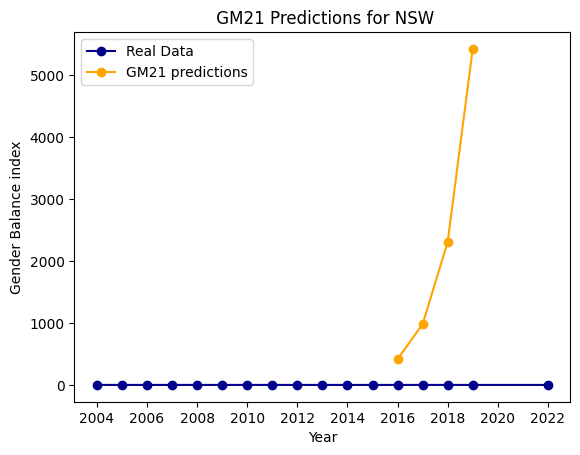

In [8]:
plt.plot(df.index, df['NSW'], label='Real Data',color='darkblue',  marker='o')
plt.plot(pred.index, pred['predictions'], label="GM21 predictions", color='orange', marker='o')
plt.xticks(ticks=df.index, labels=df.index)
plt.xticks(ticks=np.arange(2004, 2023, 2), labels=np.arange(2004, 2023, 2))
plt.grid(False)
plt.xlabel('Year')
plt.ylabel('Gender Balance index')
plt.title(f' GM21 Predictions for NSW')
plt.legend()
plt.show()

# Grey Model (2,1): All calculation by Australian state/territory

In [9]:
territories = list(df.columns.values)  # Extracting territory names from DataFrame columns
predic_GM21 = pd.DataFrame()  # Creating an empty DataFrame to store predictions

# Iterating over each territory
for state in territories:

    x0 = np.array(df[state][0:17])  # Extracting initial 17 data points for the current territory

    # Setting up symbolic variables for differential equation
    t = symbols('t')
    x = Function('x')(t)

    n = len(x0)
    x1 = np.cumsum(x0)  # Cumulative sum of the initial data points
    a_x0 = np.diff(x0)
    a_x0 = np.concatenate([[0], a_x0])  # Concatenating a zero at the beginning

    # Calculating midpoint values
    z = np.zeros(n)
    for i in range(1, n):
        z[i] = 0.5 * (x1[i] + x1[i - 1])

    # Setting up the system of equations for solving the differential equation
    B = np.column_stack((-x0[1:], -z[1:], np.ones(n - 1)))
    Y = a_x0[1:]

    # Solving the differential equation system
    u, _, _, _ = lstsq(B, Y, rcond=None)
    a1, a2, b, = u[0], u[1], u[2]
    diff_eq = Eq(diff(x, t, t) + a1 * diff(x, t) + a2 * x, b)

    # Defining initial conditions
    ics = {x.subs(t, 0): x1[0], x.subs(t, 5): x1[-1]}

    # Solving the differential equation with initial conditions
    solution = dsolve(diff_eq, ics=ics)

    # Extracting predicted values from the solution
    yuce = [solution.rhs.subs(t, val).evalf() for val in range(n)]
    x0_hat = [yuce[0]] + np.diff(yuce).tolist()  # Reconstructing the original data

    # Adding the reconstructed data to the prediction DataFrame
    predic_GM21[state] = x0_hat

    # Calculating the error between the observed and predicted data
    epsilon = x0 - x0_hat  # Error between observed and predicted data


## PLot GM (2,1) predictions

In [10]:
predic_GM21["Years "]=range(2004,2021)
predic_GM21=predic_GM21.set_index("Years ")
pred_GM21 = predic_GM21.iloc[-5:-1]
#pred_GM21

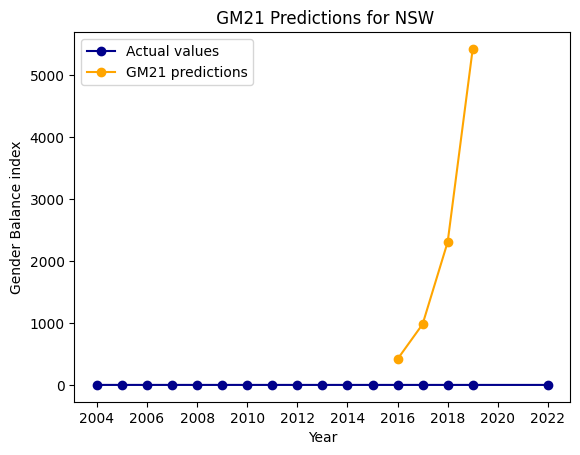

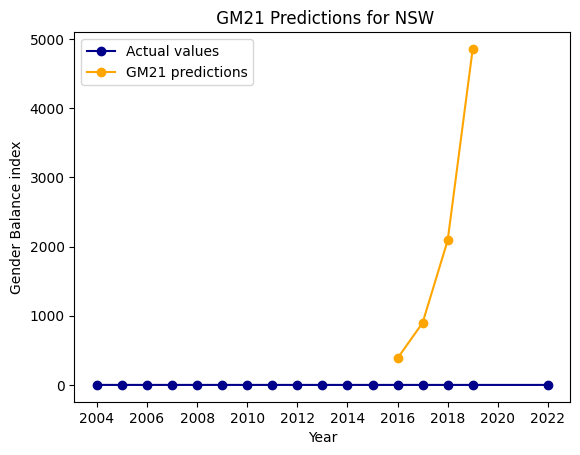

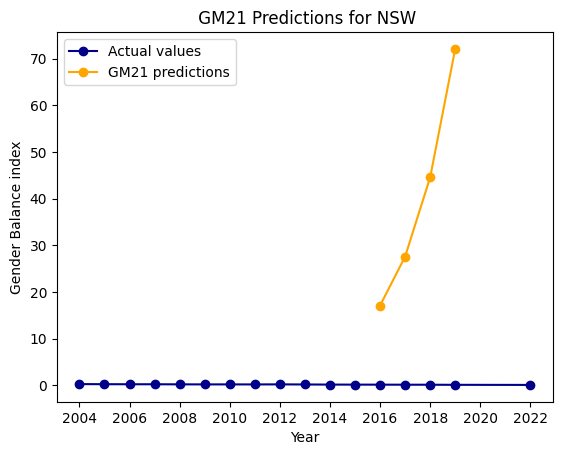

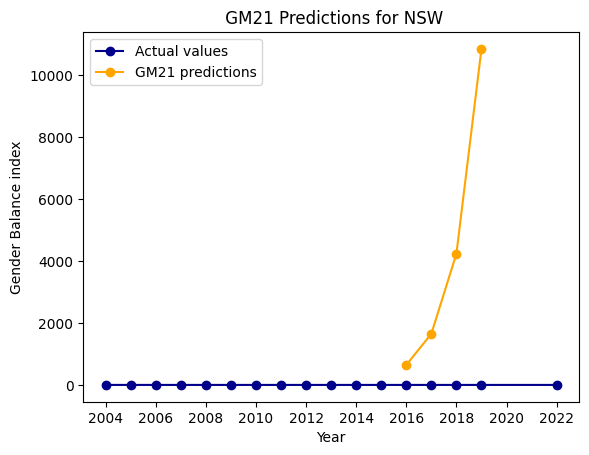

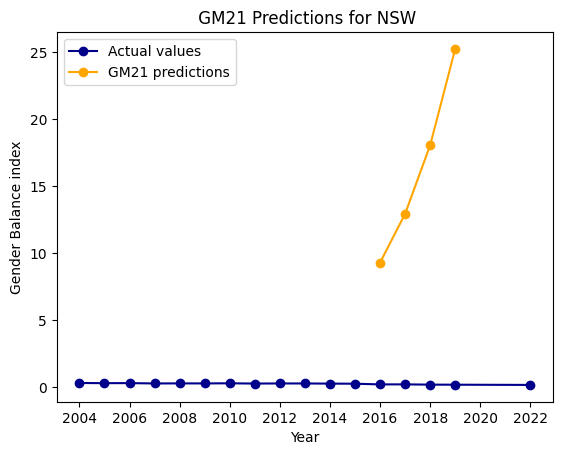

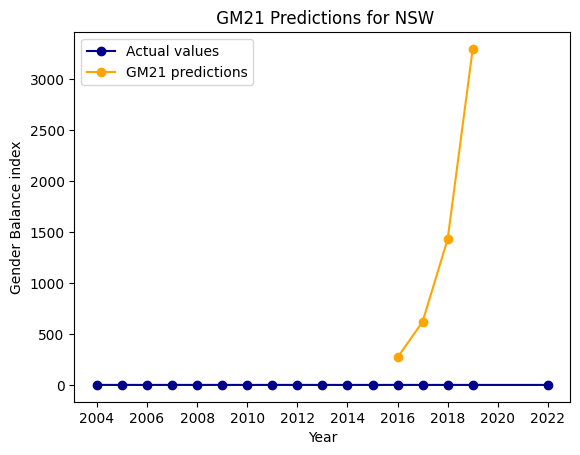

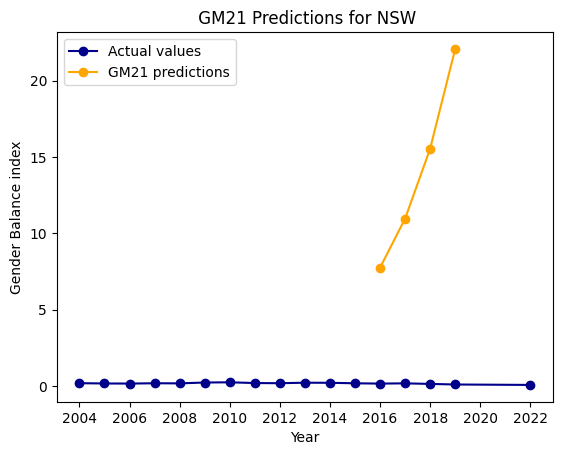

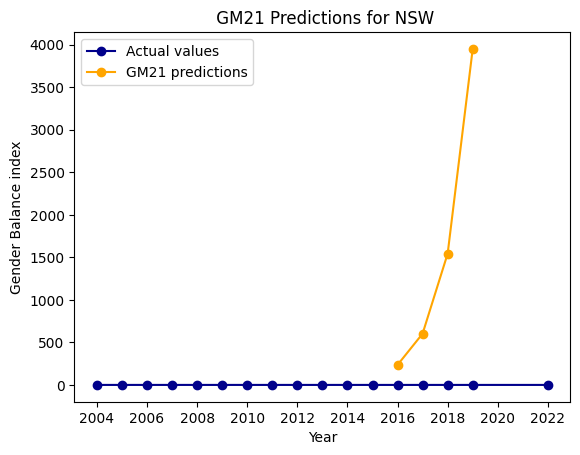

In [11]:
#Display each graph separately.
for state in territories:
        plt.plot(df.index, df[state], label='Actual values', color='darkblue',  marker='o')
        plt.plot(pred_GM21.index, pred_GM21[state], label='GM21 predictions', color='orange', marker='o')
        plt.xticks(ticks=df.index, labels=df.index)
        plt.xticks(ticks=np.arange(2004, 2023, 2), labels=np.arange(2004, 2023, 2))
        plt.grid(False)
        plt.legend(loc="upper right")
        plt.xlabel('Year')
        plt.ylabel('Gender Balance index')
        plt.title(f' GM21 Predictions for NSW')
        plt.legend()
        plt.show()

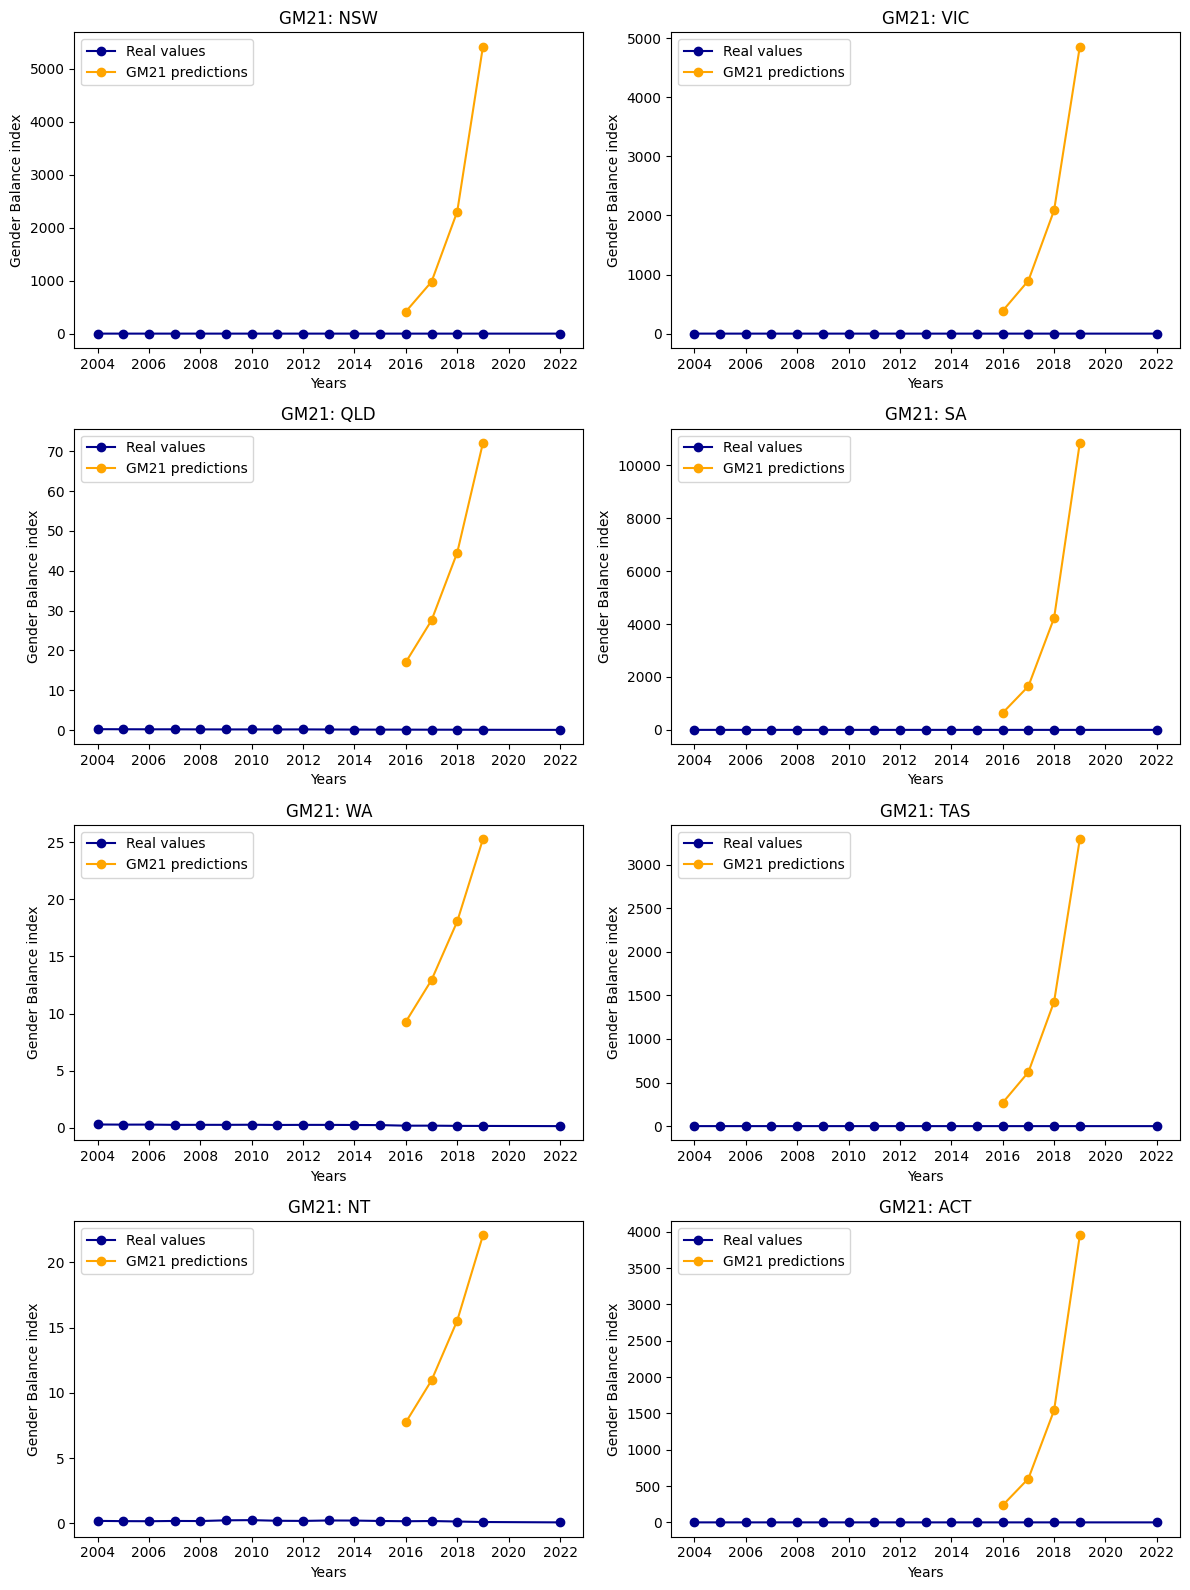

In [12]:
# Define the list of territories for the second dataset
territories_au = list(df.columns.values)  # Replace df_2 with your second dataset

# Create subplots with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Loop through each territory
for i, state in enumerate(territories_au):
    # Plot real data from the first dataset
    axs[i].plot(df.index, df[state], label='Real values',color='darkblue',  marker='o')
    # Plot predictions from the first dataset
    axs[i].plot(pred_GM21.index, pred_GM21[state], label='GM21 predictions', color='orange', marker='o')
    # Set x-axis ticks and labels from 2004 to 2022 in steps of 2
    axs[i].set_xticks(ticks=np.arange(2004, 2023, 2))
    axs[i].set_xticklabels(labels=np.arange(2004, 2023, 2))
    # Set labels and title
    axs[i].set_xlabel('Years')
    axs[i].set_ylabel('Gender Balance index')
    axs[i].set_title(f'GM21: {state}')
    # Add legend
    axs[i].legend()
    # Hide grid
    axs[i].grid(False)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## METRICS

In [13]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

real_data=df.copy()
real_data=real_data.iloc[:-1]
real_data=real_data.tail(4)

territories_au=list(real_data.columns.values)
metrics={}
for states in territories_au:
  mape = np.mean(np.abs((real_data[states].values - pred_GM21[states])/real_data[states].values)) * 100
  mse=sqrt(mean_squared_error(pred_GM21[states],real_data[states]))
  mae = mean_absolute_error(real_data[states].values, pred_GM21[states])
  metrics[states]={"MAPE": mape, "MSE":mse, "MAE":mae}

metric_results_GM21= pd.DataFrame.from_dict(metrics)
metric_results_GM21

,NSW,VIC,QLD,SA,WA,TAS,NT,ACT
MAPE,1.607873e+06,1.454830e+06,41512.257057,4.322971e+06,8882.081861,1.448671e+06,11984.144232,3.855150e+06
MSE,2.992351e+03,2.687721e+03,45.272224,5.891595e+03,17.271689,1.826357e+03,14.959022,2.144968e+03
MAE,2.280086e+03,2.056830e+03,40.206936,4.345863e+03,16.195081,1.402650e+03,13.946192,1.582997e+03


# Save Predictions & Metrics

In [14]:
# metric_results_GM21.to_csv("metrics_GM21.csv")
# files.download('metrics_GM21.csv')

# pred_GM21.to_csv('pred_GM21.csv')
# files.download('pred_GM21.csv')